## Q2. Document Classification

## Q2.1 Reuters Dataset
first we will copy the code which downlond the dataset from out of the core classification tutorial.

In [ ]:
from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

In [31]:
class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            sys.stdout.write(
                '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

## Q2.1.1 Descriptive Statistics

after we downloanded the dataset, lets load it and print some statistics.

In [32]:
data_stream = pd.DataFrame(stream_reuters_documents('../data/reuters'))
print(data_stream)

downloading dataset (once and for all) into ../data/reuters
downloaded 8.15 MB / 8.15 MBuntarring Reuters dataset...
done.
                                                   title  \
0                                     BAHIA COCOA REVIEW   
1              STANDARD OIL <SRD> TO FORM FINANCIAL UNIT   
2             TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN   
3           TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER   
4       NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE   
...                                                  ...   
21573  JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES   
21574      SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987   
21575     SIX KILLED IN SOUTH AFRICAN GOLD MINE ACCIDENT   
21576   PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES   
21577   AMERICAN EXCHANGE INTRODUCES INSTITUTIONAL INDEX   

                                                    body  \
0      Showers continued throughout the week in the B...   
1      Standard Oil Co and BP North 

we can see that there are 21578 documents in that dataset, lets see the number of unique categories(topics).

In [36]:
unique_topics = set()
for topics in data_stream['topics']:
    unique_topics.update(topics)
print(unique_topics)

{'netherlands', 'ose', 'sumita', 'dkr', 'steeg', 'groundnut-oil', 'comecon', 'iran', 'bresser-pereira', 'iwcc', 'lesotho', 'vietnam', 'chirac', 'syria', 'concepcion', 'sunseed', 'rwanda', 'guam', 'south-korea', 'zaire', 'hk', 'indonesia', 'de-la-madrid', 'papandreou', 'young', 'tose', 'mnse', 'cameroon', 'verity', 'papua-new-guinea', 'honduras', 'ethiopia', 'aquino', 'eca', 'afghanistan', 'opec', 'heat', 'nzdlr', 'kullberg', 'eib', 'platinum', 'russell', 'israel', 'ghana', 'cruzado', 'barbados', 'guyana', 'pickens', 'saudriyal', 'austdlr', 'tin', 'zse', 'housing', 'aqazadeh', 'ipi', 'barley', 'poland', 'castorseed', 'biffex', 'adb-africa', 'simex', 'oapec', 'grain', 'cottonseed', 'crude', 'lse', 'dominican-republic', 'james-baker', 'efta', 'conable', 'nickel', 'vanuatu', 'north-korea', 'balladur', 'zambia', 'earn', 'sugar', 'morocco', 'senegal', 'austria', 'oecd', 'icco', 'bahrain', 'ciampi', 'us-virgin-islands', 'malta', 'keating', 'masse', 'paraguay', 'hog', 'pet-chem', 'coconut', 'c

we have a lot of classes in that dataset, lets try to see the number of documents per class.

In [39]:
from collections import Counter

classes_counter = Counter()
for topics in data_stream['topics']:
    classes_counter.update(topics)

print(classes_counter)

Counter({'usa': 12542, 'earn': 3987, 'acq': 2448, 'uk': 1489, 'japan': 1138, 'canada': 1104, 'money-fx': 801, 'crude': 634, 'grain': 628, 'west-germany': 567, 'trade': 552, 'interest': 513, 'france': 469, 'ec': 349, 'brazil': 332, 'wheat': 306, 'ship': 305, 'australia': 270, 'corn': 254, 'china': 223, 'dlr': 217, 'ussr': 216, 'switzerland': 214, 'belgium': 214, 'netherlands': 196, 'oilseed': 192, 'money-supply': 190, 'sugar': 184, 'iran': 179, 'italy': 170, 'james-baker': 168, 'reagan': 166, 'gnp': 163, 'coffee': 145, 'hong-kong': 142, 'veg-oil': 137, 'philippines': 136, 'gold': 135, 'nat-gas': 130, 'taiwan': 128, 'soybean': 120, 'bop': 116, 'spain': 115, 'livestock': 114, 'south-africa': 113, 'new-zealand': 112, 'cpi': 112, 'sweden': 112, 'south-korea': 111, 'imf': 106, 'indonesia': 99, 'nyse': 97, 'opec': 93, 'argentina': 90, 'iraq': 90, 'worldbank': 87, 'saudi-arabia': 87, 'reserves': 84, 'india': 82, 'thailand': 81, 'mexico': 81, 'gatt': 80, 'volcker': 79, 'copper': 78, 'malaysia':

we can allready see that there are many classes with only 1 samples, we will plot the 10 most common classes.

<BarContainer object of 10 artists>

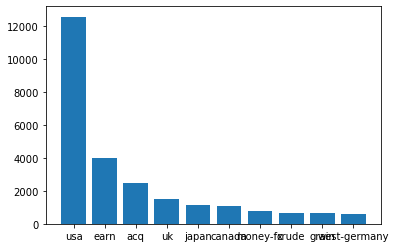

In [44]:
most_common = classes_counter.most_common(10)

plt.bar([x[0] for x in most_common], [x[1] for x in most_common])

we can see that this dataset is higly imbalanced, with the biggest class having 3*the second most common one samples. we will now print the mean,std,max,min. we know that the max is usa with 12k samples and there are alot of classes with only 1 sample(which is the min). we will only calculate the mean and std.

In [46]:
print(np.std(list(classes_counter.values())))
print(np.mean(list(classes_counter.values())))

643.9321684195976
89.87191011235954


we can see that those values are very big which supports our suspicsion that the database is higly imbalanced. we will how many words and unique words are there in the dataset.

In [49]:
from nltk import WhitespaceTokenizer

words = []
for text in data_stream['body']:
    words.extend(WhitespaceTokenizer().tokenize(text))
    
print('words in the dataset : ' + str(len(words)))
print('unique words in the dataset : ' + str(len(set(words))))

words in the dataset : 2567249
unique words in the dataset : 112342


## Q2.1.2 Partial-fit classifiers
partial fit classifiers are classifiers which can be trained only one some part of the dataset , lets consider some example(neural network), we know that neural network training method is gradient decent in which for every example(or a batch of examples) we compute the partial derivatives and we fix our weights based on the error in each layer using the chain rule. so we can see that in neural network learning method we dont actually need all the examples all the time. lets consider the oppisite method, for example linear regression(linear regression can be also train using gradient decent, but for the sake of the explaination we will consider only the regualr approch) we only need to solve 1 equation over the entire dataset, we can't solve it partialy for half of the dataset because we will get the wrong weights.

## Q2.1.3 Hashing Vectorizer
since our training is only for some batch over the dataset, we want to be able to map all the vectors to the same space because if we will encounter some unknown words, it wont affect that much on the given vector for the classifier. we want to guarantee that the features space remains the same over time(that is why we use the HashVectorizer), This is especially useful in the case of text classification where new features (words) may appear in each batch, since the dimensions are fixed the classifier won't be "surprised".

## Q2.2. BBC News Dataset
we will start by loading the dataset.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import nltk

In [2]:
train = pd.read_csv('../data/BBC News Train.csv')
test = pd.read_csv('../data/BBC News Test.csv')

## Q2.2.1 Descriptive Statistics

we will now print some statistics over the dataset in order to understund it better.

In [3]:
len(train)

1490

we can see that the document contain 1490 rows , lets explore the columns provided in the dataset.

In [4]:
print(train)

      ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          business  
...             ...  
1485 

we can see that there are 3 columns , Articleid which isn't very usefull. we have text , which is the actual text of the article and we have the category which is the classification.

In [5]:
print(train['Category'].unique())

['business' 'tech' 'politics' 'sport' 'entertainment']


we have 5 categories in the dataset , which is the above categories , lets now explore how many documents are there for each category.

<BarContainer object of 5 artists>

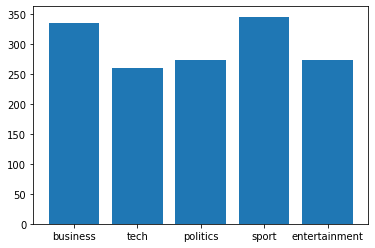

In [6]:
categories = train['Category'].unique()
documents_per_category = {}
for category in categories :
    documents_per_category[category] = len(train[train['Category'] == category])
    
plt.bar(documents_per_category.keys(), documents_per_category.values())

we can see that the data is pretty much balanced , there are about 300 articles for each category. we will now calculate the mean and the std.

In [7]:
print('mean : ' + str(np.mean(list(documents_per_category.values()))))
print('std : ' + str(np.std(list(documents_per_category.values()))))

mean : 298.0
std : 35.5471517846367


this confirms the above observations that the dataset is pretty much balanced and there are about 300 articles per category. we will now calculate the average number of words in article per category.

<BarContainer object of 5 artists>

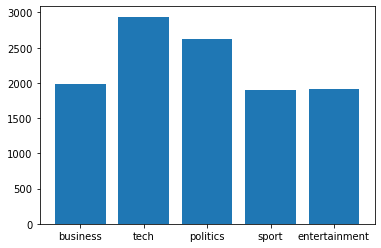

In [8]:
average_words_per_category = {}
for category in categories :
    average_words_per_category[category] = np.mean([len(x['Text']) for index,x in train[train['Category'] == category].iterrows()])
    
plt.bar(average_words_per_category.keys(), average_words_per_category.values())

we can cleary see that the mean number of words in tech and politics related articles in much bigger then everything else, lets observe the number of unique words in the articles but first we need to do a little preprocessing to our data, we will use WhitespaceTokenizer from the ntlk package for that mission.

In [9]:
from nltk.tokenize import WhitespaceTokenizer

preprocessed_articles = [WhitespaceTokenizer().tokenize(x) for x in train['Text']]
print(preprocessed_articles[0])

['worldcom', 'ex-boss', 'launches', 'defence', 'lawyers', 'defending', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'against', 'a', 'battery', 'of', 'fraud', 'charges', 'have', 'called', 'a', 'company', 'whistleblower', 'as', 'their', 'first', 'witness.', 'cynthia', 'cooper', 'worldcom', 's', 'ex-head', 'of', 'internal', 'accounting', 'alerted', 'directors', 'to', 'irregular', 'accounting', 'practices', 'at', 'the', 'us', 'telecoms', 'giant', 'in', '2002.', 'her', 'warnings', 'led', 'to', 'the', 'collapse', 'of', 'the', 'firm', 'following', 'the', 'discovery', 'of', 'an', '$11bn', '(£5.7bn)', 'accounting', 'fraud.', 'mr', 'ebbers', 'has', 'pleaded', 'not', 'guilty', 'to', 'charges', 'of', 'fraud', 'and', 'conspiracy.', 'prosecution', 'lawyers', 'have', 'argued', 'that', 'mr', 'ebbers', 'orchestrated', 'a', 'series', 'of', 'accounting', 'tricks', 'at', 'worldcom', 'ordering', 'employees', 'to', 'hide', 'expenses', 'and', 'inflate', 'revenues', 'to', 'meet', 'wall', 'street', 'earn

In [10]:
unique_words = set([word for article in preprocessed_articles for word in article])
print(len(unique_words))

35594


we will split our dataset to 80% train, 20% test as Michael suggested

In [11]:
msk = np.random.rand(len(train)) < 0.8

new_train = train[msk]
new_test = train[~msk]

In [12]:
train_preprocessed_articles = [WhitespaceTokenizer().tokenize(x) for x in new_train['Text']]

## Q2.2.2 Feature Extraction

now we need to create features for our model, we will use doc2vec for that. the main idea of doc2vec unlike word2vec is to create a vector of the entire document and not for just a single word, and when those document have so connection between them, then those vectors cosine distance we be very close and hopfully our logistic regression will be able to notice that. so we will first train our doc2vec on the train dataset.

In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(article, [i]) for i, article in enumerate(train_preprocessed_articles)]
model = Doc2Vec(documents, vector_size=64, window=2, min_count=1, workers=4, epochs=40)

we will then create a train set which consits of those vectors, and try to train the logistic regression. if that process won't achieve good results, we will then try to extract some manual features.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

x_train = [model.infer_vector(article) for article in train_preprocessed_articles]
y_train = new_train['Category']

logistic_model = LogisticRegression(max_iter=300)
logistic_model.fit(x_train,y_train)
logistic_model.score(x_train, y_train)

1.0

## Q2.2.3 Model Training and Evaluation

we can see that the model is preforming very well on the train data, it might be an overfit, lets try to evaluate it on the test data to see the results.

In [15]:
test_preprocessed_articles = [WhitespaceTokenizer().tokenize(x) for x in new_test['Text']]
x_test = [model.infer_vector(article) for article in test_preprocessed_articles]
y_test = new_test['Category']

y_pred = logistic_model.predict(x_test)
print(classification_report(y_pred, y_test))

               precision    recall  f1-score   support

     business       0.94      0.94      0.94        65
entertainment       1.00      0.94      0.97        70
     politics       0.93      0.93      0.93        57
        sport       0.99      1.00      0.99        68
         tech       0.92      0.98      0.95        50

     accuracy                           0.96       310
    macro avg       0.96      0.96      0.96       310
 weighted avg       0.96      0.96      0.96       310



we can see that the model accuracy is 96%, where politics and tech are the worst ones with 93% and 92% precision respectivly. we will try to increase the vector size of the doc2vec model, to achive higher accuracy.

In [16]:
documents = [TaggedDocument(article, [i]) for i, article in enumerate(train_preprocessed_articles)]
model = Doc2Vec(documents, vector_size=128, window=2, min_count=1, workers=4, epochs=40)

In [17]:
x_train = [model.infer_vector(article) for article in train_preprocessed_articles]
y_train = new_train['Category']

logistic_model = LogisticRegression(max_iter=300)
logistic_model.fit(x_train,y_train)
logistic_model.score(x_train, y_train)

1.0

In [18]:
test_preprocessed_articles = [WhitespaceTokenizer().tokenize(x) for x in new_test['Text']]
x_test = [model.infer_vector(article) for article in test_preprocessed_articles]
y_test = new_test['Category']

y_pred = logistic_model.predict(x_test)
print(classification_report(y_pred, y_test))

               precision    recall  f1-score   support

     business       0.97      0.95      0.96        66
entertainment       0.98      0.94      0.96        69
     politics       0.93      0.96      0.95        55
        sport       0.99      1.00      0.99        68
         tech       0.96      0.98      0.97        52

     accuracy                           0.97       310
    macro avg       0.97      0.97      0.97       310
 weighted avg       0.97      0.97      0.97       310



we can see that the tech precision is increased by 4%, and the ovrall acurracy is increased by 1%, we will use that model as our final model, lets plot the confusion matrix.

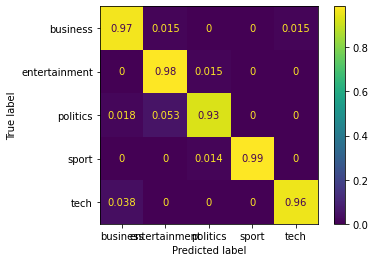

In [19]:
plot_confusion_matrix(logistic_model, x_test, y_test, normalize='true')

that model perform very well, we can see that the diagonal values are much higer than anything in the chart, it makes only a few mistakes.